In [1]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils
from torchvision import transforms
from PIL import Image
import pandas as pd 
import random
import torch

torch.manual_seed(101)
torch.cuda.manual_seed(101)
random.seed(101)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 0.7.0


In [2]:
data_path = Path.cwd() / 'datasets'
dataset_path = utils.download_dataset('mango leaves',
                                   dest_path=data_path,
                                   extract=True)
dataset_path = dataset_path / 'Root' / 'Original'

Downloading:
MangoLeafBD: A comprehensive image dataset to classify diseased and healthy mango leaves
> Authors: Sarder Iftekhar Ahmed, Muhammad Ibrahim, Md. Nadim
> Year: 2023
> Website: https://www.sciencedirect.com/science/article/pii/S2352340923000598

File already exists


Extracting Root.zip: 100%|██████████| 13428/13428 [00:06<00:00, 1928.05it/s]


In [3]:
images = list(dataset_path.rglob('*.jpg'))

Image size: (640, 480)


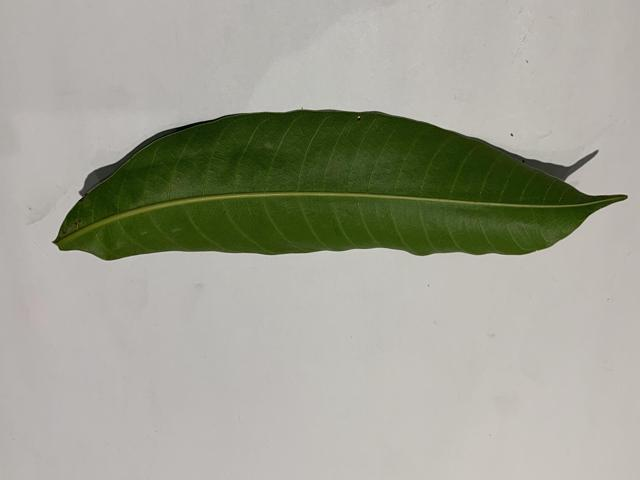

In [4]:
rnd_img = random.choice(images)
img = Image.open(rnd_img)
print(f"Image size: {img.size}")
img


(640, 480)


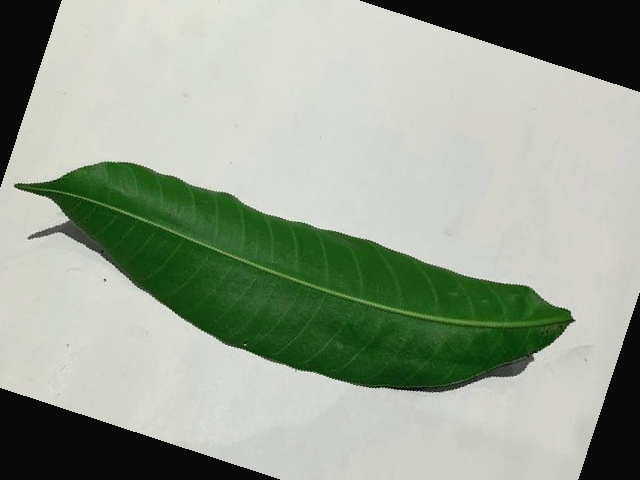

In [5]:
img = Image.open(rnd_img)
ts = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])
img = ts(img)
print(img.size)
img

In [6]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(32 * 56 * 56, 6)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        return x

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

ts = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

ds = ImageFolder(dataset_path, transform=ts)
ds.classes

['Amrapali Mango',
 'Banana Mango',
 'Chaunsa Mango',
 'Fazli Mango',
 'Haribhanga Mango',
 'Himsagar Mango']

In [8]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [0.7, 0.15, 0.15])
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

SimpleCNN Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\sp_03_model_v1.pt


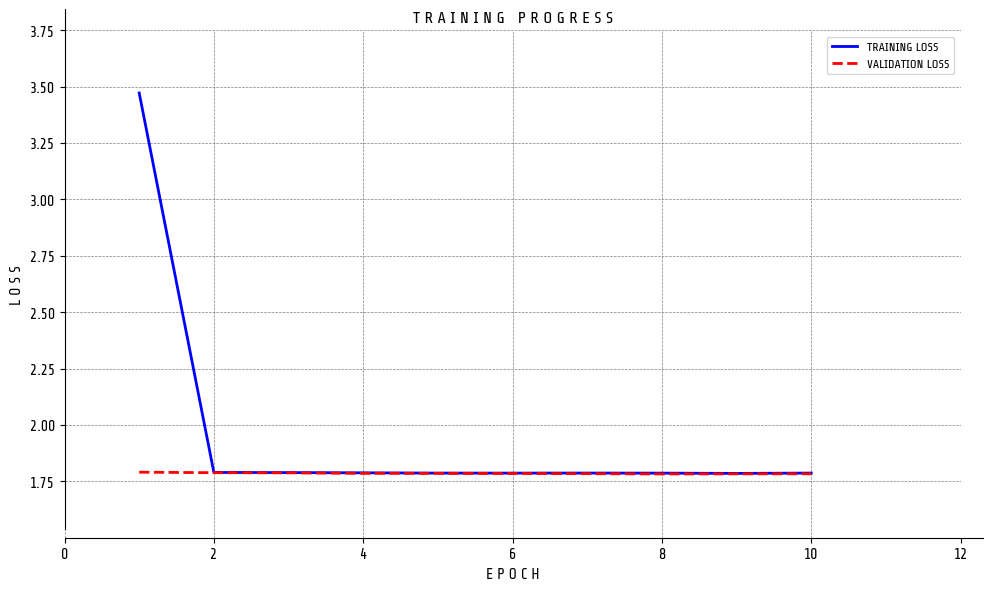

In [9]:
modelv1 = SimpleCNN()

optimiser = torch.optim.Adam(modelv1.parameters(), lr=5e-3)
criterion = torch.nn.CrossEntropyLoss()


num_epochs = 10

modelv1 = utils.train_model(modelv1,
                  criterion,
                  optimiser,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs,
                  early_stopping=True,
                  patience=5,
                  save_path= Path.cwd() / "my_models" / "sp_03_model_v1.pt",
                  plot_loss=True)

    

In [10]:
def compute_accuracy(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    acc = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).type(torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            acc += utils.accuracy_score(labels, predicted)

    return acc / len(test_dataloader)



In [11]:
modelv1.load_state_dict(torch.load(Path.cwd() / "my_models" / "sp_03_model_v1.pt"))
test_accuracy = compute_accuracy(modelv1, test_dl)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.2565


In [12]:
import torchvision.models as models

EfficientNet Training:   0%|          | 0/40 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\sp_03_model_v3.pt


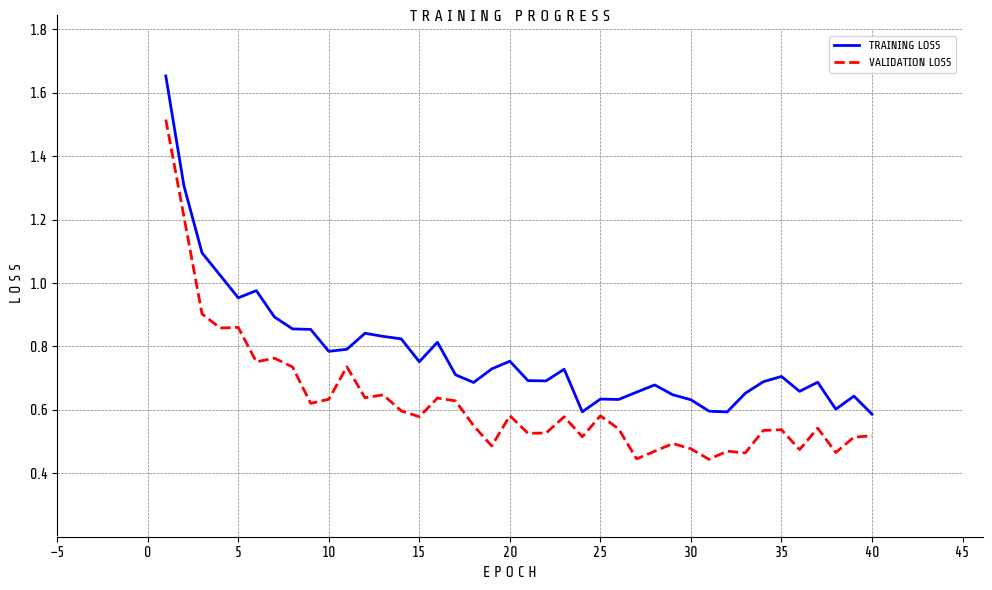

In [13]:

model_v3 = models.efficientnet_b0(weights='DEFAULT')
n_features = model_v3.classifier[1].in_features
model_v3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_features, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 6))

for param in model_v3.features.parameters():
    param.requires_grad = False

for param in model_v3.classifier.parameters():
    param.requires_grad = True

criterion_v3 = torch.nn.CrossEntropyLoss()
optimiser_v3 = torch.optim.Adam(model_v3.parameters(), lr=1e-3)
num_epochs = 40
model_v3 = utils.train_model(model_v3,
                  criterion_v3,
                  optimiser_v3,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs,
                  early_stopping=True,
                  tolerance=0.01,
                  patience=5,
                  save_path= Path.cwd() / "my_models" / "sp_03_model_v3.pt",
                  plot_loss=True)

In [14]:
# model_v3.load_state_dict(torch.load(Path.cwd() / "my_models" / "sp_03_model_v3.pt"))
test_accuracy = compute_accuracy(model_v3, test_dl)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.8257


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v3.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v3(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=ds.classes))

                  precision    recall  f1-score   support

  Amrapali Mango       0.64      0.64      0.64        14
    Banana Mango       0.97      0.94      0.95        32
   Chaunsa Mango       0.88      0.79      0.84        29
     Fazli Mango       0.74      0.85      0.79        20
Haribhanga Mango       0.65      0.79      0.71        14
  Himsagar Mango       0.79      0.69      0.73        16

        accuracy                           0.81       125
       macro avg       0.78      0.78      0.78       125
    weighted avg       0.82      0.81      0.81       125



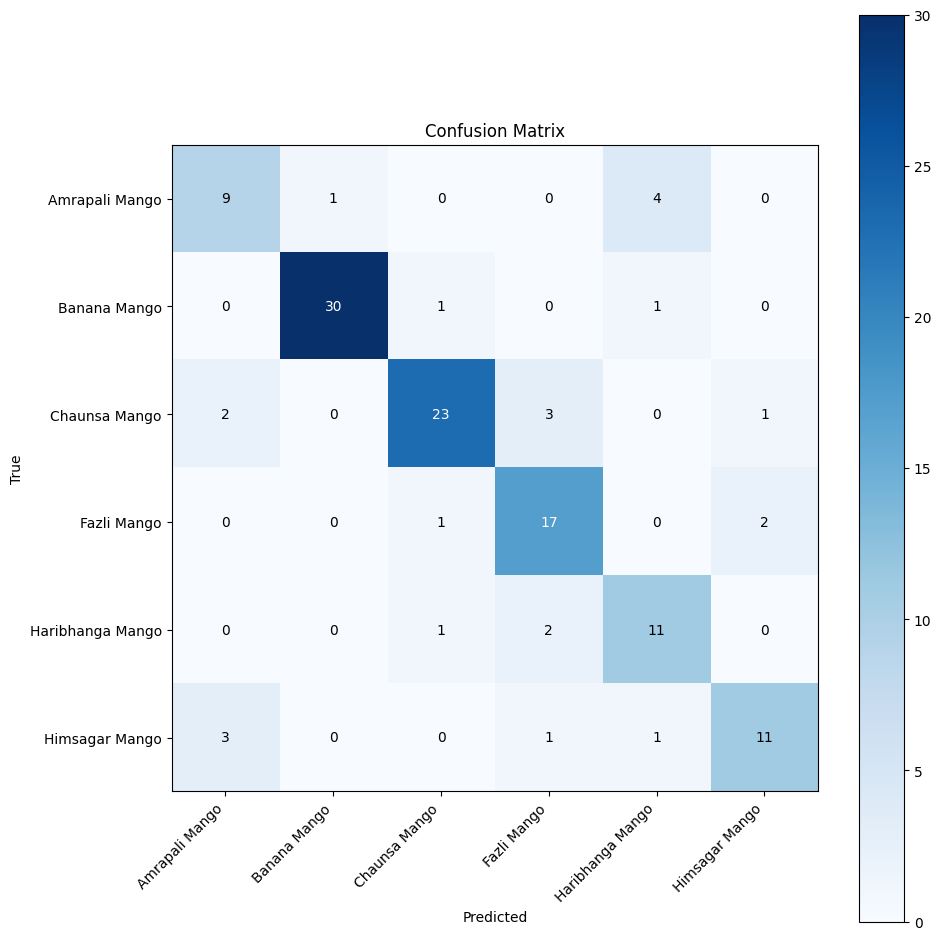

In [16]:
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# Create confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
plt.colorbar(im)

# Add labels to each cell
for i in range(len(ds.classes)):
    for j in range(len(ds.classes)):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", 
                      color="white" if cm[i, j] > cm.max()/2 else "black")

# Add class labels
ax.set_xticks(np.arange(len(ds.classes)))
ax.set_yticks(np.arange(len(ds.classes)))
ax.set_xticklabels(ds.classes, rotation=45, ha='right')
ax.set_yticklabels(ds.classes)

# Add titles
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [17]:
# Prediction on a single image
image_path = Path.cwd() / 'figs' / 'mango_leaf.png'
img = Image.open(image_path)
img = img.resize((160, 160))
img = ts(img)
img = img.unsqueeze(0)  # Add batch dimension
img = img.to(device)

model_v3.eval()
with torch.no_grad():
    output = model_v3(img)
    _, predicted = torch.max(output, 1)
    predicted_class = ds.classes[predicted.item()]

print(f"Predicted class: {predicted_class}")

Predicted class: Banana Mango


In [18]:
# Fine-tuning the last few layers
model_v3 = models.efficientnet_b0(weights='DEFAULT')


In [19]:
model_v3

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet Training:   0%|          | 0/40 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\sp_03_model_v5.pt


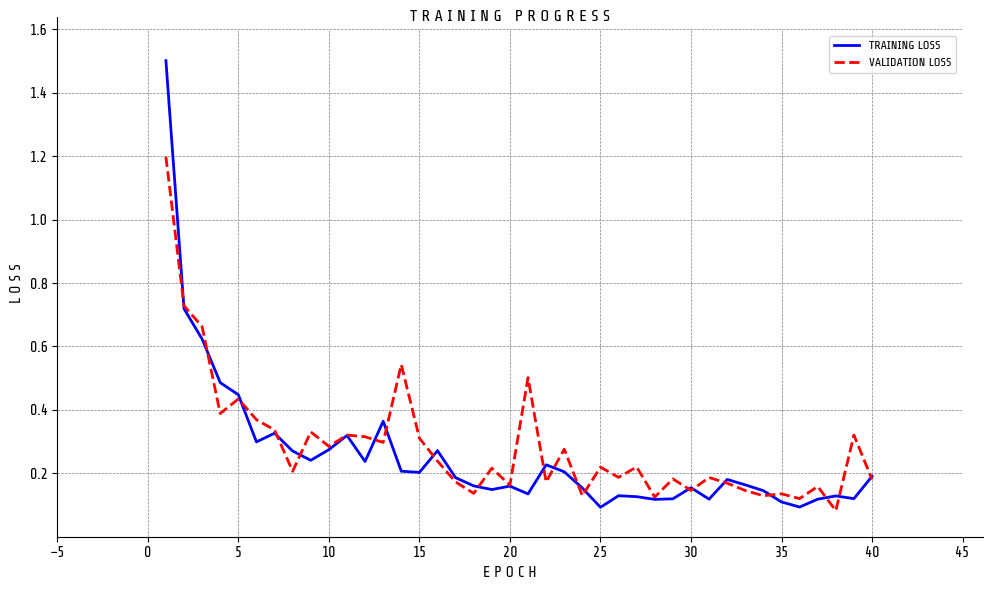

In [20]:
n_features = model_v3.classifier[1].in_features

for param in model_v3.parameters():
    param.requires_grad = False

for param in model_v3.features[-3:].parameters():
    param.requires_grad = True

model_v3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_features, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 6))

criterion_v3 = torch.nn.CrossEntropyLoss()
optimiser_v3 = torch.optim.Adam(model_v3.parameters(), lr=1e-3)
num_epochs = 40

model_v3 = utils.train_model(model_v3,
                  criterion_v3,
                  optimiser_v3,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs,
                  early_stopping=True,
                  tolerance=0.01,
                  patience=5,
                  save_path= Path.cwd() / "my_models" / "sp_03_model_v5.pt",
                  plot_loss=True)

In [21]:
# model_v3.load_state_dict(torch.load(Path.cwd() / "my_models" / "sp_03_model_v5.pt"))
test_accuracy = compute_accuracy(model_v3, test_dl)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9445


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v3.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v3(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=ds.classes))

                  precision    recall  f1-score   support

  Amrapali Mango       0.87      0.93      0.90        14
    Banana Mango       1.00      0.91      0.95        32
   Chaunsa Mango       0.87      0.93      0.90        29
     Fazli Mango       0.95      0.90      0.92        20
Haribhanga Mango       1.00      0.93      0.96        14
  Himsagar Mango       0.83      0.94      0.88        16

        accuracy                           0.92       125
       macro avg       0.92      0.92      0.92       125
    weighted avg       0.93      0.92      0.92       125



In [23]:
# Prediction on a single image
image_path = Path.cwd() / 'figs' / 'mango_leaf.png'
img = Image.open(image_path)
img = img.resize((160, 160))
img = ts(img)
img = img.unsqueeze(0)  # Add batch dimension
img = img.to(device)

model_v3.eval()
with torch.no_grad():
    output = model_v3(img)
    _, predicted = torch.max(output, 1)
    predicted_class = ds.classes[predicted.item()]

print(f"Predicted class: {predicted_class}")

Predicted class: Chaunsa Mango
